Exploration and Normalization

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/birdsong-recognition/train.csv
/kaggle/input/birdsong-recognition/example_test_audio_metadata.csv
/kaggle/input/birdsong-recognition/test.csv
/kaggle/input/birdsong-recognition/example_test_audio_summary.csv
/kaggle/input/birdsong-recognition/sample_submission.csv
/kaggle/input/birdsong-recognition/train_audio/perfal/XC463087.mp3
/kaggle/input/birdsong-recognition/train_audio/perfal/XC294044.mp3
/kaggle/input/birdsong-recognition/train_audio/perfal/XC393752.mp3
/kaggle/input/birdsong-recognition/train_audio/perfal/XC213531.mp3
/kaggle/input/birdsong-recognition/train_audio/perfal/XC213533.mp3
/kaggle/input/birdsong-recognition/train_audio/perfal/XC391901.mp3
/kaggle/input/birdsong-recognition/train_audio/perfal/XC198259.mp3
/kaggle/input/birdsong-recognition/train_audio/perfal/XC184351.mp3
/kaggle/input/birdsong-recognition/train_audio/perfal/XC488748.mp3
/kaggle/input/birdsong-recognition/train_audio/perfal/XC365189.mp3
/kaggle/input/birdsong-recognition/train_audio/perf

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Audio, clear_output, display, HTML

import librosa
import librosa.display



In [3]:
sample_file = "/kaggle/input/birdsong-recognition/train_audio/scoori/XC265149.mp3"
# sample_file = "/kaggle/input/birdsong-recognition/example_test_audio/BLKFR-10-CPL_20190611_093000.pt540.mp3"
sample_audio = librosa.load(sample_file)
y, sr = sample_audio

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [4]:
sample_audio, y.shape[0], sr

((array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 22050), 3730752, 22050)

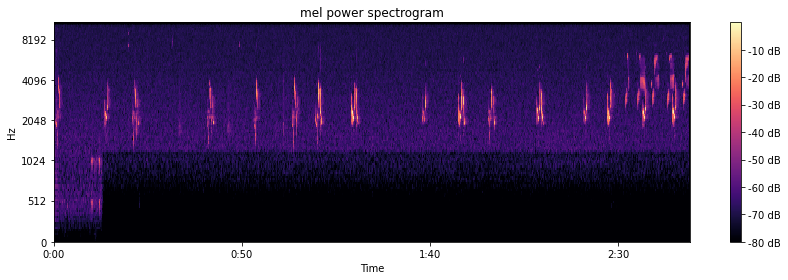

In [5]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

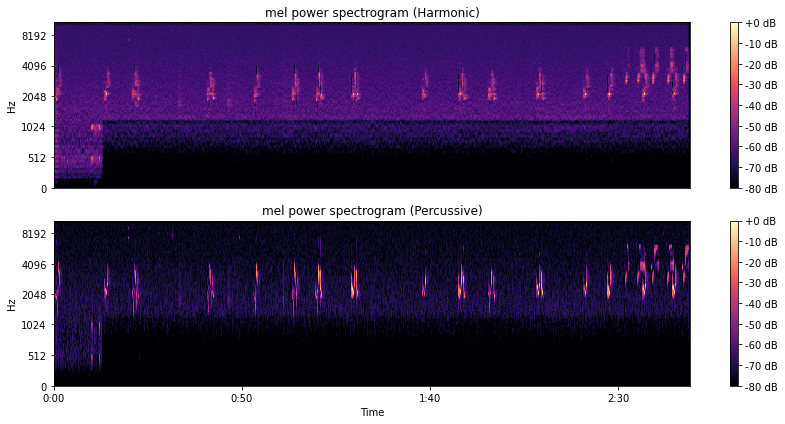

In [6]:
# Harmonic-percussive source separation
# Before doing any signal analysis, let's pull apart the harmonic and percussive components of the audio. This is pretty easy to do with the effects module.

y_harmonic, y_percussive = librosa.effects.hpss(y)
# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Harmonic)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Percussive)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

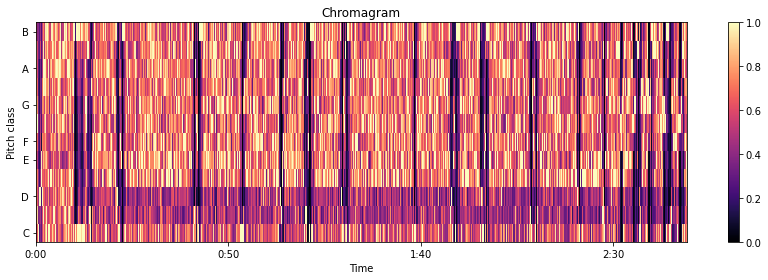

In [7]:
# Chromagram
# Next, we'll extract Chroma features to represent pitch class information.

# We'll use a CQT-based chromagram with 36 bins-per-octave in the CQT analysis.  An STFT-based implementation also exists in chroma_stft()
# We'll use the harmonic component to avoid pollution from transients
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, bins_per_octave=36)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

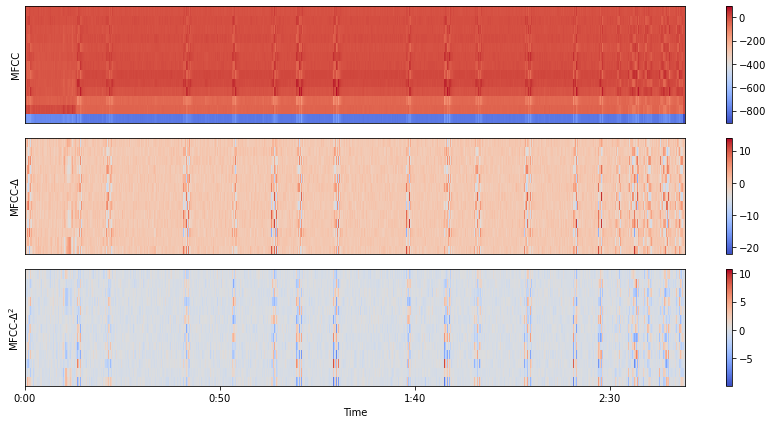

In [8]:
# MFCC
# Mel-frequency cepstral coefficients are commonly used to represent texture or timbre of sound.

# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

<Figure size 864x432 with 0 Axes>

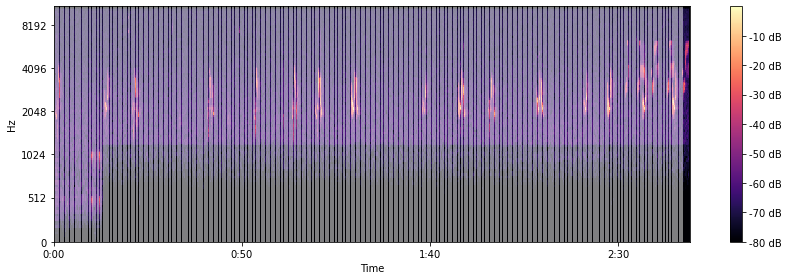

In [9]:
# Beat tracking
# The beat tracker returns an estimate of the tempo (in beats per minute) and frame indices of beat events.
# The input can be either an audio time series (as we do below), or an onset strength envelope as calculated by librosa.onset.onset_strength().

# Now, let's run the beat tracker.
# We'll use the percussive component for this part
plt.figure(figsize=(12, 6))
tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)

# Let's re-draw the spectrogram, but this time, overlay the detected beats
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Let's draw transparent lines over the beat frames
plt.vlines(librosa.frames_to_time(beats),
           1, 0.5 * sr,
           colors='w', linestyles='-', linewidth=2, alpha=0.5)

plt.axis('tight')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout();

In [10]:
print('Estimated tempo:        %.2f BPM' % tempo)

print('First 5 beat frames:   ', beats[:5])

# Frame numbers are great and all, but when do those beats occur?
print('First 5 beat times:    ', librosa.frames_to_time(beats[:5], sr=sr))

# We could also get frame numbers from times by librosa.time_to_frames()

Estimated tempo:        89.10 BPM
First 5 beat frames:    [  4  29  53  82 110]
First 5 beat times:     [0.09287982 0.67337868 1.2306576  1.90403628 2.55419501]


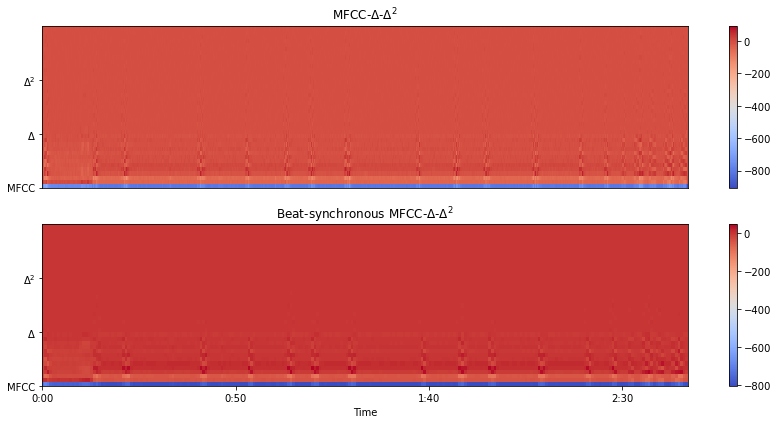

In [11]:
# Beat-synchronous feature aggregation
# Once we've located the beat events, we can use them to summarize the feature content of each beat.

# This can be useful for reducing data dimensionality, and removing transient noise from the features.
# feature.sync will summarize each beat event by the mean feature vector within that beat

M_sync = librosa.util.sync(M, beats)

plt.figure(figsize=(12,6))

# Let's plot the original and beat-synchronous features against each other
plt.subplot(2,1,1)
librosa.display.specshow(M)
plt.title('MFCC-$\Delta$-$\Delta^2$')

# We can also use pyplot *ticks directly
# Let's mark off the raw MFCC and the delta features
plt.yticks(np.arange(0, M.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])

plt.colorbar()

plt.subplot(2,1,2)
# librosa can generate axis ticks from arbitrary timestamps and beat events also
librosa.display.specshow(M_sync, x_axis='time',
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))

plt.yticks(np.arange(0, M_sync.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])             
plt.title('Beat-synchronous MFCC-$\Delta$-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

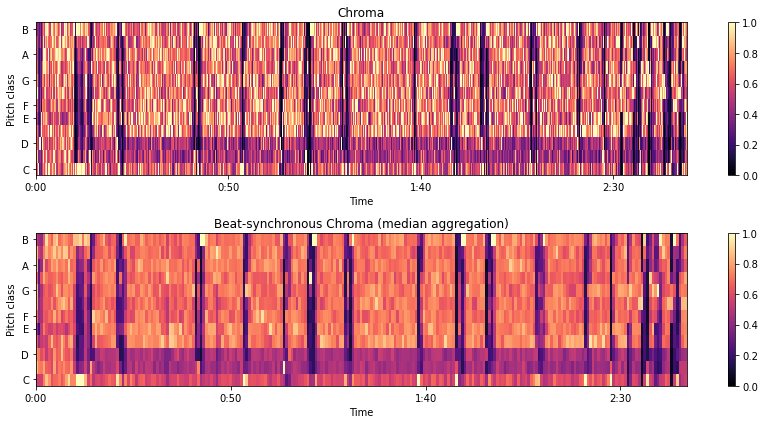

In [12]:
# Beat synchronization is flexible.
# Instead of computing the mean delta-MFCC within each beat, let's do beat-synchronous chroma
# We can replace the mean with any statistical aggregation function, such as min, max, or median.

C_sync = librosa.util.sync(C, beats, aggregate=np.median)

plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
librosa.display.specshow(C, sr=sr, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time')

plt.title('Chroma')
plt.colorbar()

plt.subplot(2, 1, 2)
librosa.display.specshow(C_sync, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time', 
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))


plt.title('Beat-synchronous Chroma (median aggregation)')

plt.colorbar()
plt.tight_layout()

# Get annotation data

In [13]:
train_df = pd.read_csv("../input/birdsong-recognition/train.csv")
train_df.shape

(21375, 35)

In [14]:
train_df[train_df.filename=="XC265149.mp3"].T.to_dict()

{17316: {'rating': 4.5,
  'playback_used': nan,
  'ebird_code': 'scoori',
  'channels': '1 (mono)',
  'date': '2012-04-01',
  'pitch': 'both',
  'duration': 169,
  'filename': 'XC265149.mp3',
  'speed': 'level',
  'species': "Scott's Oriole",
  'number_of_notes': '7-20',
  'title': "XC265149 Scott's Oriole (Icterus parisorum)",
  'secondary_labels': '[\'Geococcyx californianus_Greater Roadrunner\', "Thryomanes bewickii_Bewick\'s Wren"]',
  'bird_seen': nan,
  'sci_name': 'Icterus parisorum',
  'location': ' Paradise Cemetery, Chiricahua Mountains, Cochise County, Arizona',
  'latitude': '31.933',
  'sampling_rate': '44100 (Hz)',
  'type': 'song',
  'elevation': '1600 m',
  'description': 'playback-used:no',
  'bitrate_of_mp3': '128000 (bps)',
  'file_type': 'mp3',
  'volume': 'increasing',
  'background': "Greater Roadrunner (Geococcyx californianus); Bewick's Wren (Thryomanes bewickii)",
  'xc_id': 265149,
  'url': 'https://www.xeno-canto.org/265149',
  'country': 'United States',
  '

In [15]:
y.shape[0]/sr

169.19510204081632